# Tweet Sentiment prediction
The task is to create a model that preidcts whether a tweet has positive, neutral or negative tone. 

###Files
* tweet_train.csv - the training set

### Columns
* textID - unique ID for each piece of text
* text - the text of the tweet
* sentiment - the general sentiment of the tweet
* selected_text - [train only] the text that supports the tweet's sentiment

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


In [105]:
import pandas as pd
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [58]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [60]:
data = pd.read_csv('tweet_train.csv')

### Analyzing the tweet_train.csv dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
data.isna().any()

textID           False
text              True
selected_text     True
sentiment        False
dtype: bool

In [24]:
data.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


### Preprocessing tweet_train.csv

In [37]:
stop_words = (stopwords.words('english'))

In [38]:
print(stop_words[0:15])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours']


In [73]:
# Clean the tweets, return cleaned text
def clean_tweet(text): 

    # removing numeric values
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if not any(c.isdigit() for c in word))

    if isinstance(text, str):
      # Convert to lowercase 
      text = text.lower() 

      # removing stop words 
      words = [word for word in text.split() if word not in stop_words]
      text = ' '.join(words)

      # Remove punctuation 
      text = re.sub(r'[^a-zA-Z\s]', '', text) 

      # Remove mentions
      text = re.sub(r'@[A-Za-z0-9]+', '', text) 
      
      # Remove URLs
      text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)

      # Tokenizing 
      tokens = word_tokenize(text)

      # Lemmatization
      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(word) for word in tokens]

      text = ' '.join(tokens)

    return text

In [68]:
# Applying clean_tweet function to tweet column
data['text'] = data['text'].apply(clean_tweet)

In [69]:
data['text']

0                                       id responded going
1                                  sooo sad miss san diego
2                                          bos bullying me
3                                    interview leave alone
4                   son couldnt put release already bought
                               ...                        
27476    wish could come see u denver husband lost job ...
27477    ive wondered rake to client made clear net onl...
27478    yay good you enjoy break probably need hectic ...
27479                                                worth
27480                     flirting going atg smile yay hug
Name: text, Length: 27480, dtype: object

#### Removing NaN values because there are only few of them

In [63]:
data  = data.dropna(axis="rows")

### Mapping sentiment column, negative sentiment equals 0, neutral 1 and positive 2. 

In [64]:
class_map = {'negative': 0, 'neutral' : 1, 'positive' : 2}

In [65]:
data['sentiment'] = data['sentiment'].map(class_map)

In [70]:
data.head(7)

,textID,text,selected_text,sentiment
0,cb774db0d1,id responded going,"I`d have responded, if I were going",1
1,549e992a42,sooo sad miss san diego,Sooo SAD,0
2,088c60f138,bos bullying me,bullying me,0
3,9642c003ef,interview leave alone,leave me alone,0
4,358bd9e861,son couldnt put release already bought,"Sons of ****,",0
5,28b57f3990,httpwwwdothebouncycomsmf shameless plugging be...,http://www.dothebouncy.com/smf - some shameles...,1
6,6e0c6d75b1,feeding baby fun smile coo,fun,2


How are the classes distributed?

In [53]:
data['sentiment'].value_counts()

1    11117
2     8582
0     7781
Name: sentiment, dtype: int64

<Axes: >

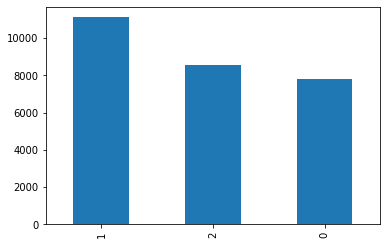

In [54]:
data['sentiment'].value_counts().plot(kind = 'bar')

#### Spliting data info training and testing using train-test split. 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'] , test_size=0.2, random_state=42)

Vectorizing the text data

In [88]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [90]:
X_train.shape

(21984, 22362)

#### Model 1. Logistic regression

In [92]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Predicting and accuracy of the model 1.

In [118]:
y_pred = model1.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy on test data: " , accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1572
           1       0.62      0.74      0.68      2236
           2       0.77      0.72      0.74      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.68      0.68      5496
weighted avg       0.69      0.68      0.68      5496

Accuracy on test data:  0.6846797671033479


### Model 2. Naive Bayes classifier

In [112]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'] , test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model2 = MultinomialNB()
model2.fit(X_train, y_train)

MultinomialNB()

#### Predicting and accuracy of the model 2.

In [117]:
y_pred = model2.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy on test data: " , accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.38      0.51      1572
           1       0.54      0.84      0.66      2236
           2       0.76      0.57      0.65      1688

    accuracy                           0.62      5496
   macro avg       0.69      0.60      0.61      5496
weighted avg       0.68      0.62      0.61      5496

Accuracy on test data:  0.6242721979621543
